
# Классификация по тональности отзывов (banki.ru) — Colab Notebook (Python 3.12)

Этот ноутбук выполняет три части задания:
1. **Анализ текстов** (EDA): распределения по городам/банкам, длины отзывов, частотные списки, кривые Ципфа и Хипса, ответы на вопросы, TF‑IDF ключевые слова/биграммы для оценок 1 и 5.  
2. **Тематическое моделирование**: LDA (gensim) с разным числом тем, поиск тем про конкретные банки.  
3. **Классификация**: бинарная (оценка 1 vs 5) с разными вариантами векторизации (uni/bi/tri‑граммы слов, символьные n‑граммы), а также варианты с LSA (SVD) и с LDA‑темами.



## Установка зависимостей
Если запуск в Colab — выполните ячейку ниже (перезапуск ядра **не требуется**).


In [53]:

!pip -q install --upgrade pip
# Базовые библиотеки
!pip -q install pandas numpy matplotlib scikit-learn tqdm nltk razdel pymorphy3 gensim==4.3.3
# Визуализация (необязательно)
!pip -q install seaborn



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip
ERROR: To modify pip, please run the following command:
C:\Users\lipatov\AppData\Local\Programs\Python\Python312\python.exe -m pip -q install --upgrade pip

[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip


^C



[notice] A new release of pip is available: 25.1.1 -> 25.2
[notice] To update, run: python.exe -m pip install --upgrade pip



## Импорт библиотек и загрузка стоп‑слов NLTK
Мы используем русские стоп‑слова из NLTK. **WordNet не требуется**.


In [ ]:

import os, re, bz2, json, random, math
from collections import Counter, defaultdict
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from tqdm import tqdm

# Токенизация/лемматизация
from razdel import tokenize as razdel_tokenize
import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords
RU_STOP = set(stopwords.words('russian'))

import pymorphy3 as pymorphy
MORPH = pymorphy.MorphAnalyzer()

# ML/Vectorization/Topic Modeling
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer, TfidfTransformer
from sklearn.decomposition import TruncatedSVD, LatentDirichletAllocation
from sklearn.linear_model import LogisticRegression
from sklearn.svm import LinearSVC
from sklearn.pipeline import Pipeline
from sklearn.metrics import accuracy_score, f1_score, classification_report
from sklearn.base import TransformerMixin, BaseEstimator

import gensim
from gensim import corpora
from gensim.models.ldamodel import LdaModel

random.seed(42)
np.random.seed(42)



## Загрузка данных


In [ ]:

# ==== НАСТРОЙКИ ПОЛЬЗОВАТЕЛЯ ====
DATA_PATH = "./content/banki_responses.json.bz2"
DATA_URL  = ""

# ==== СКАЧИВАНИЕ (если указан DATA_URL) ====
if DATA_URL:
    import urllib.request
    local_name = os.path.basename(DATA_URL.split('?')[0])
    print("Скачиваю:", DATA_URL, "->", local_name)
    urllib.request.urlretrieve(DATA_URL, local_name)
    DATA_PATH = f"/content/{local_name}" if not os.path.exists(local_name) else local_name

assert DATA_PATH, "Укажите DATA_PATH (или DATA_URL), чтобы продолжить."


In [ ]:
import bz2, json, os, re
import numpy as np
import pandas as pd

def _open_text(path):
    return bz2.open(path, 'rt', encoding='utf-8') if path.endswith('.bz2') else open(path, 'r', encoding='utf-8')

def load_responses_any(path: str) -> pd.DataFrame:
    """
    Универсальный загрузчик:
    - обычный JSON: объект с полем 'responses' ИЛИ массив объектов
    - JSON Lines (NDJSON): по одному JSON-объекту на строку
    - «склеенные» JSON по строкам
    Нормализует ключевые поля: text/city/bank/rating_grade.
    """
    def normalize_to_df(items):
        df = pd.json_normalize(items)
        # текст
        text_col = next((c for c in ['body','text','content','review_text'] if c in df.columns), None)
        if text_col is None:
            # найти самый «текстовый» столбец
            candidates = [c for c in df.columns if df[c].dtype == 'object']
            if not candidates:
                raise ValueError("Не найден столбец с текстом отзыва.")
            text_col = max(candidates, key=lambda c: df[c].astype(str).str.len().mean())

        city_col  = next((c for c in ['city','geo.city','author.city','location'] if c in df.columns), None)
        bank_col  = next((c for c in ['bank_name','bank.title','org.title','bank'] if c in df.columns), None)
        rating_col= next((c for c in ['rating_grade','rating','score'] if c in df.columns), None)

        out = pd.DataFrame({
            'text': df[text_col].astype(str),
            'city': df[city_col] if city_col in df else None,
            'bank': df[bank_col] if bank_col in df else None,
            'rating_grade': pd.to_numeric(df[rating_col], errors='coerce') if rating_col in df else np.nan,
        })
        return out

    # 1) Пытаемся как обычный JSON (объект/массив)
    try:
        with _open_text(path) as f:
            data = json.load(f)
        if isinstance(data, dict) and 'responses' in data:
            return normalize_to_df(data['responses'])
        elif isinstance(data, list):
            return normalize_to_df(data)
        else:
            raise ValueError("JSON загружен, но не найден массив отзывов (нет 'responses' и не массив).")
    except json.JSONDecodeError:
        pass  # идём в JSONL/построчный разбор

    # 2) Постатейно: JSON Lines или «склейка» по строкам
    items = []
    with _open_text(path) as f:
        for line in f:
            s = line.strip()
            if not s:
                continue
            # убрать возможные запятые в конце (часто в JSONL)
            s = re.sub(r',$', '', s)
            try:
                obj = json.loads(s)
                items.append(obj)
            except json.JSONDecodeError:
                parts = re.split(r'}\s*{', s)
                if len(parts) > 1:
                    recs = []
                    for i,p in enumerate(parts):
                        if i == 0:
                            chunk = p + '}'
                        elif i == len(parts)-1:
                            chunk = '{' + p
                        else:
                            chunk = '{' + p + '}'
                        try:
                            recs.append(json.loads(chunk))
                        except Exception:
                            pass
                    items.extend(recs)

    if not items:
        raise ValueError("Не удалось распарсить файл ни как JSON, ни как JSON Lines.")

    # Если каждая запись — объект с ключом 'responses', расплющим
    if all(isinstance(x, dict) and 'responses' in x for x in items):
        flat = []
        for x in items:
            if isinstance(x.get('responses'), list):
                flat.extend(x['responses'])
        if flat:
            return normalize_to_df(flat)

    # Иначе предполагаем, что каждая запись — отзыв
    return normalize_to_df(items)

df = load_responses_any(DATA_PATH)
print(df.shape)
df.head(3)


(201030, 4)


,text,city,bank,rating_grade
0,Здравствуйте! Хотелось бы выразить благодарно...,г. Воронеж,ВТБ 24,5.0
1,Уважаемые представители департамента по работе...,г. Казань,Русский Стандарт,2.0
2,Здравствуйте. Столкнулась с такой ситуацией. в...,г. Санкт-Петербург,Союз,2.0



## Опционально: случайная подвыборка (20–25%)
Если вычисления слишком долгие — включите подсэмпл.


In [ ]:

USE_SUBSAMPLE = True   # False, чтобы использовать весь датасет
SUBSAMPLE_FRAC = 0.22  # 20–25%

if USE_SUBSAMPLE and 0 < SUBSAMPLE_FRAC < 1.0:
    df = df.sample(frac=SUBSAMPLE_FRAC, random_state=42).reset_index(drop=True)
print("Размер после подвыборки:", df.shape)


Размер после подвыборки: (44227, 4)



## Предобработка текста: токенизация и лемматизация (русский)
- Токены: `razdel`
- Леммы: `pymorphy2`
- Стоп‑слова: русские из NLTK


In [ ]:

def clean_text(s: str) -> str:
    s = s.lower()
    # Сохраняем кириллицу/латиницу и цифры, заменяя прочее на пробел
    s = re.sub(r"[^a-zа-яё0-9\s]", " ", s)
    s = re.sub(r"\s+", " ", s).strip()
    return s

def tokenize_ru(s: str):
    return [t.text for t in razdel_tokenize(s)]

def lemmatize_ru(tokens):
    lemmas = []
    for tok in tokens:
        p = MORPH.parse(tok)
        if not p:
            lemmas.append(tok)
        else:
            lemmas.append(p[0].normal_form)
    return lemmas

def pos_is_noun(token):
    p = MORPH.parse(token)
    if not p:
        return False
    return p[0].tag.POS == 'NOUN'

# Кэширование для ускорения
from functools import lru_cache

@lru_cache(maxsize=100000)
def lemma_cached(token):
    p = MORPH.parse(token)
    return p[0].normal_form if p else token

def preprocess_series(series: pd.Series, do_lemmas=True):
    texts_clean = series.fillna(" ").astype(str).map(clean_text)
    tokens = [tokenize_ru(s) for s in tqdm(texts_clean, desc="tokenize")]
    if do_lemmas:
        lemmas = [[lemma_cached(tok) for tok in toks] for toks in tqdm(tokens, desc="lemmas")]
        return tokens, lemmas
    return tokens, None

tokens, lemmas = preprocess_series(df['text'], do_lemmas=True)


lemmas: 100%|██████████| 44227/44227 [00:19<00:00, 2243.69it/s]



# Часть 1. Анализ текстов



### 1) Количество отзывов по городам и банкам


,count
city,
г. Москва,16390
г. Санкт-Петербург,4051
None,3406
г. Екатеринбург,713
г. Новосибирск,685
г. Нижний Новгород,548
г. Ростов-на-Дону,539
г. Самара,519
г. Казань,435


,count
bank,
Сбербанк России,6740
Альфа-Банк,2945
Русский Стандарт,2385
ВТБ 24,2342
Хоум Кредит Банк,2287
Тинькофф Банк,1711
Национальный Банк «Траст»,1329
Связной Банк,1195
Ренессанс Кредит,1187


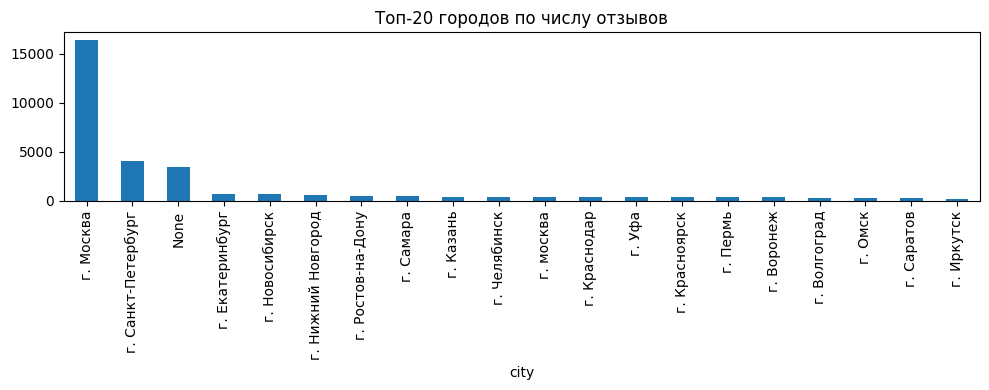

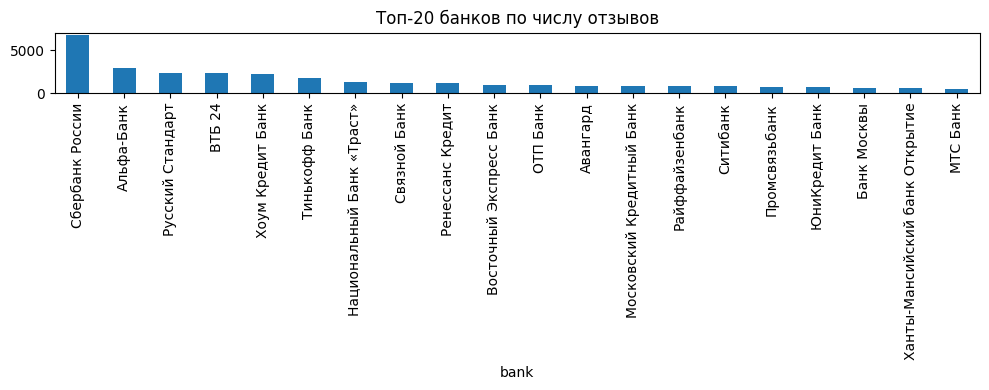

In [38]:

city_counts = df['city'].value_counts(dropna=False).head(20)
bank_counts = df['bank'].value_counts(dropna=False).head(20)

display(city_counts.to_frame('count').head(20))
display(bank_counts.to_frame('count').head(20))

fig = plt.figure(figsize=(10,4))
city_counts.plot(kind='bar')
plt.title('Топ-20 городов по числу отзывов')
plt.tight_layout()
plt.show()

fig = plt.figure(figsize=(10,4))
bank_counts.plot(kind='bar')
plt.title('Топ-20 банков по числу отзывов')
plt.tight_layout()
plt.show()



### 2) Гистограммы длин отзывов (в символах и словах)


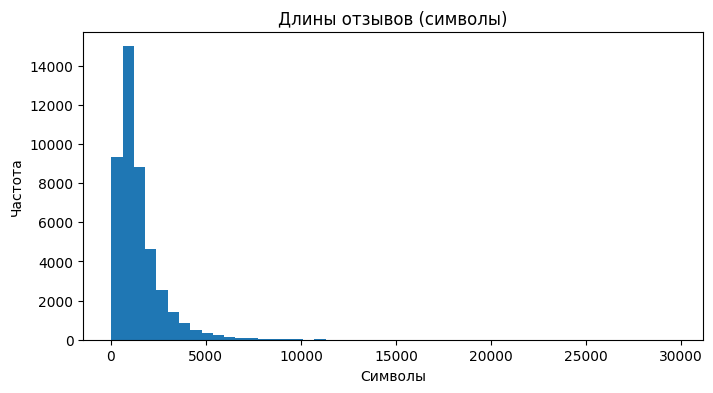

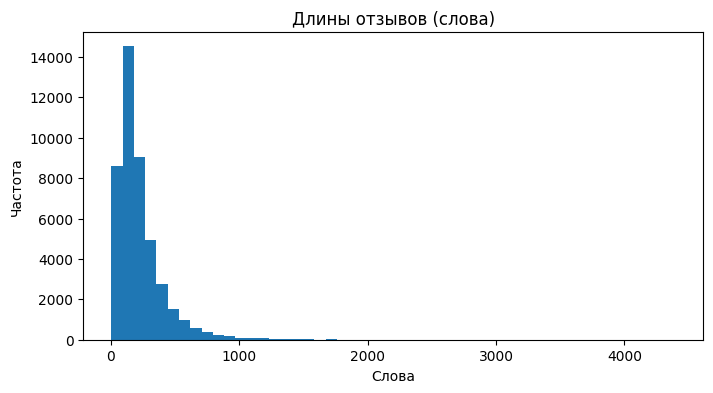

In [39]:

length_chars = df['text'].fillna('').astype(str).map(len)
length_words = pd.Series([len(t) for t in tokens])

fig = plt.figure(figsize=(8,4))
plt.hist(length_chars, bins=50)
plt.title('Длины отзывов (символы)')
plt.xlabel('Символы')
plt.ylabel('Частота')
plt.show()

fig = plt.figure(figsize=(8,4))
plt.hist(length_words, bins=50)
plt.title('Длины отзывов (слова)')
plt.xlabel('Слова')
plt.ylabel('Частота')
plt.show()



### 3) Частотные списки
- 10 самых частых **слов**
- 10 самых частых **слов без стоп‑слов**
- 10 самых частых **лемм**
- 10 самых частых **лемм‑существительных**


In [50]:
def top10(counter):
    return pd.DataFrame(counter.most_common(10), columns=['term', 'freq'])


all_tokens = [tok for doc in tokens for tok in doc]
ctr_tokens = Counter(all_tokens)

display(top10(ctr_tokens).style.hide(axis='index'))

tokens_ns = [t for t in all_tokens if t not in RU_STOP and len(t) > 1]
ctr_tokens_ns = Counter(tokens_ns)

display(top10(ctr_tokens_ns).style.hide(axis='index'))

all_lemmas = [l for doc in lemmas for l in doc]
ctr_lemmas = Counter(all_lemmas)

display(top10(ctr_lemmas).style.hide(axis='index'))

lemmas_nouns = [l for l in all_lemmas if pos_is_noun(l)]
ctr_lemmas_nouns = Counter(lemmas_nouns)

display(top10(ctr_lemmas_nouns).style.hide(axis='index'))

term,freq
в,357377
и,289645
не,229521
на,190174
что,171322
я,155285
с,125397
по,100499
мне,86549
банка,76125


term,freq
банка,76125
банк,60772
это,49897
деньги,35321
карту,28433
карты,26294
кредит,24212
день,20436
банке,20297
очень,19303


term,freq
в,364183
я,302200
и,289645
не,229521
на,190174
банк,187145
что,177866
с,141465
быть,117932
по,100499


term,freq
банк,187145
карта,88489
деньга,48194
день,46218
кредит,45605
клиент,38278
счёт,38194
отделение,37704
сотрудник,36783
мочь,35091



### 4) Кривые Ципфа (Zipf) и Хипса (Heaps)


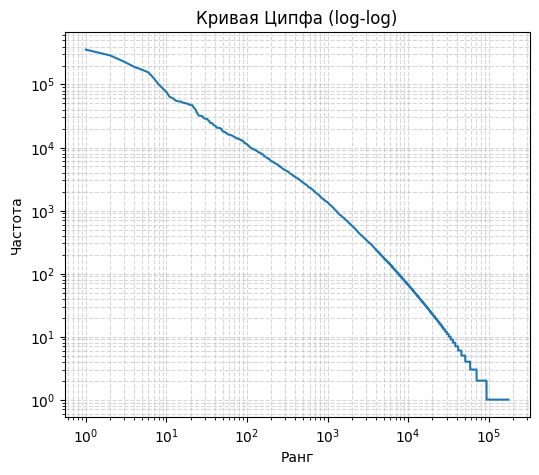

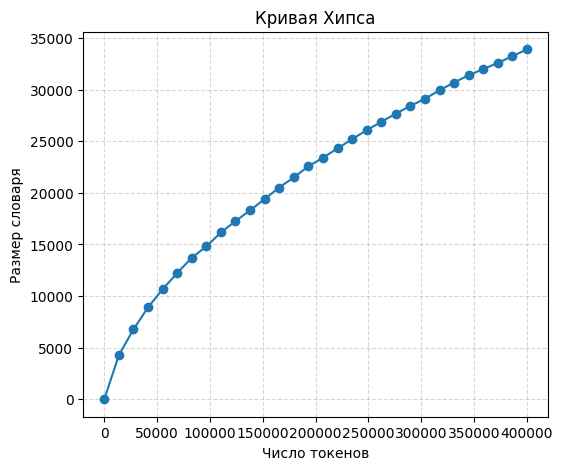

In [ ]:

freqs = np.array(sorted(ctr_tokens.values(), reverse=True))
ranks = np.arange(1, len(freqs)+1)

fig = plt.figure(figsize=(6,5))
plt.loglog(ranks, freqs)
plt.title('Кривая Ципфа (log-log)')
plt.xlabel('Ранг')
plt.ylabel('Частота')
plt.grid(True, which='both', ls='--', alpha=0.5)
plt.show()

# Heaps: рост словаря от числа токенов
def heaps_curve(sample_tokens, steps=20):
    total = len(sample_tokens)
    points = []
    seen = set()
    for k in np.linspace(1, total, steps, dtype=int):
        for t in sample_tokens[points[-1][0] if points else 0 : k]:
            seen.add(t)
        points.append((k, len(seen)))
    xs = [p[0] for p in points]
    ys = [p[1] for p in points]
    return xs, ys

sample_for_heaps = all_tokens if len(all_tokens) < 400_000 else all_tokens[:400_000]
xs, ys = heaps_curve(sample_for_heaps, steps=30)
fig = plt.figure(figsize=(6,5))
plt.plot(xs, ys, marker='o')
plt.title('Кривая Хипса')
plt.xlabel('Число токенов')
plt.ylabel('Размер словаря')
plt.grid(True, ls='--', alpha=0.5)
plt.show()



### 5) Ответы на вопросы
- Что встречается чаще: **«сотрудник»** или **«клиент»**?  
- Сколько раз встречаются слова **«мошенничество»** и **«доверие»**?
(Считаем по леммам, регистр не важен.)


In [42]:

lemma_counts = ctr_lemmas

for w in ['сотрудник', 'клиент', 'мошенничество', 'доверие']:
    print(w, '->', lemma_counts.get(w, 0))

if lemma_counts.get('сотрудник',0) > lemma_counts.get('клиент',0):
    print("Чаще встречается: 'сотрудник'")
elif lemma_counts.get('сотрудник',0) < lemma_counts.get('клиент',0):
    print("Чаще встречается: 'клиент'")
else:
    print("Встречаются одинаково часто.")


сотрудник -> 36783
клиент -> 38278
мошенничество -> 858
доверие -> 589
Чаще встречается: 'клиент'



### 6) TF‑IDF ключевые слова и биграммы для оценок 1 и 5


In [43]:

def top_tfidf_terms(texts, ngram_range=(1,2), top_k=25, min_df=5):
    vec = TfidfVectorizer(ngram_range=ngram_range, min_df=min_df, max_df=0.9)
    X = vec.fit_transform(texts)
    terms = np.array(vec.get_feature_names_out())
    # усредняем веса по документам и берём топ
    avg_scores = np.asarray(X.mean(axis=0)).ravel()
    top_idx = np.argsort(-avg_scores)[:top_k]
    return pd.DataFrame({'term': terms[top_idx], 'score': avg_scores[top_idx]})

pos_texts = df.loc[df['rating_grade']==5, 'text'].fillna('').astype(str).tolist()
neg_texts = df.loc[df['rating_grade']==1, 'text'].fillna('').astype(str).tolist()

print("Положительные (5):")
display(top_tfidf_terms(pos_texts))

print("Отрицательные (1):")
display(top_tfidf_terms(neg_texts))


Положительные (5):


,term,score
0,не,0.045734
1,на,0.044190
2,что,0.036327
3,по,0.028164
4,банка,0.026158
5,все,0.025085
6,за,0.024055
7,мне,0.023522
8,банк,0.022541
9,очень,0.022295


Отрицательные (1):


,term,score
0,что,0.044211
1,мне,0.028058
2,по,0.027379
3,банка,0.023574
4,банк,0.020481
5,за,0.017956
6,то,0.017792
7,как,0.017581
8,меня,0.017537
9,это,0.017294



# Часть 2. Тематическое моделирование (gensim LDA)


In [44]:

# Подготовка корпуса: используем леммы без стоп‑слов
docs_lemmas = [[w for w in doc if w not in RU_STOP and len(w) > 2] for doc in lemmas]
dictionary = corpora.Dictionary(docs_lemmas)
dictionary.filter_extremes(no_below=5, no_above=0.5)
corpus = [dictionary.doc2bow(doc) for doc in docs_lemmas]

def train_lda(num_topics=10, passes=5, random_state=42):
    lda = LdaModel(corpus=corpus, id2word=dictionary, num_topics=num_topics,
                   random_state=random_state, passes=passes, alpha='auto', eta='auto')
    return lda

topic_models = {}
for k in [5, 10, 15]:
    lda = train_lda(num_topics=k, passes=5)
    topic_models[k] = lda
    print(f"\n==== Топ темы для k={k} ====")
    for tid, terms in lda.print_topics(num_topics=k, num_words=10):
        print(f"Topic {tid}: {terms}")



==== Топ темы для k=5 ====
Topic 0: 0.050*"карта" + 0.018*"счёт" + 0.011*"средство" + 0.009*"операция" + 0.008*"сбербанк" + 0.008*"заявление" + 0.007*"услуга" + 0.007*"деньга" + 0.007*"который" + 0.007*"смс"
Topic 1: 0.015*"звонить" + 0.014*"телефон" + 0.014*"номер" + 0.014*"звонок" + 0.014*"сотрудник" + 0.012*"ваш" + 0.009*"позвонить" + 0.009*"заявка" + 0.009*"ответ" + 0.009*"сказать"
Topic 2: 0.028*"деньга" + 0.017*"карта" + 0.017*"отделение" + 0.012*"банкомат" + 0.011*"сказать" + 0.010*"счёт" + 0.009*"ещё" + 0.009*"мочь" + 0.008*"работать" + 0.006*"очередь"
Topic 3: 0.038*"кредит" + 0.022*"сумма" + 0.016*"платёж" + 0.016*"договор" + 0.014*"кредитный" + 0.013*"год" + 0.010*"руб" + 0.010*"месяц" + 0.009*"рубль" + 0.009*"задолженность"
Topic 4: 0.016*"вклад" + 0.015*"клиент" + 0.011*"очень" + 0.009*"сотрудник" + 0.008*"весь" + 0.008*"свой" + 0.008*"который" + 0.007*"офис" + 0.007*"вопрос" + 0.007*"год"

==== Топ темы для k=10 ====
Topic 0: 0.016*"договор" + 0.012*"документ" + 0.011*"з


### Поиск тем про конкретные банки
Находим темы, где встречаются **«сбербанк»**, **«втб»** или упоминания «банк» (для других банков).


In [45]:

def topics_with_terms(lda, query_terms=('сбербанк','втб','банк'), topn=15):
    results = []
    for tid in range(lda.num_topics):
        terms = lda.show_topic(tid, topn=topn)
        terms_only = [t for t,_ in terms]
        if any(q in terms_only for q in query_terms):
            results.append((tid, terms))
    return results

for k, lda in topic_models.items():
    hits = topics_with_terms(lda)
    print(f"\n>>>> k={k}: темы с банками:")
    if not hits:
        print("(нет явных упоминаний в топ-словах темы)")
    for tid, terms in hits:
        print(f"Topic {tid}: {terms}")



>>>> k=5: темы с банками:
Topic 0: [('карта', 0.050453704), ('счёт', 0.017860996), ('средство', 0.011443192), ('операция', 0.00924528), ('сбербанк', 0.0084367115), ('заявление', 0.008104822), ('услуга', 0.0074693924), ('деньга', 0.0071116746), ('который', 0.007057543), ('смс', 0.006712231), ('интернет', 0.006189055), ('получить', 0.0059309048), ('ответ', 0.005706635), ('клиент', 0.0056941793), ('перевод', 0.0056345654)]

>>>> k=10: темы с банками:
Topic 5: [('деньга', 0.03869498), ('карта', 0.028941398), ('заявление', 0.027923778), ('сбербанк', 0.027409676), ('банкомат', 0.02591291), ('отделение', 0.01795529), ('счёт', 0.015102617), ('написать', 0.012605545), ('средство', 0.010799492), ('сумма', 0.009874165), ('сказать', 0.009505003), ('претензия', 0.008814231), ('операция', 0.007852455), ('снять', 0.0075135515), ('ситуация', 0.0071798745)]

>>>> k=15: темы с банками:
Topic 5: [('карта', 0.12807985), ('сбербанк', 0.101242125), ('отделение', 0.039549734), ('счёт', 0.015089579), ('зарпл


# Часть 3. Классификация текстов (1 vs 5)
Формируем подмножество отзывов с оценкой **1** и **5**. Размеры `N1`/`N2` можно ограничить.


In [ ]:

# Параметры набора
N1 = None
N2 = None

df_cls = df[df['rating_grade'].isin([1,5])].copy()
df_cls['label'] = (df_cls['rating_grade'] == 5).astype(int)

g1 = df_cls[df_cls['label']==0]
g2 = df_cls[df_cls['label']==1]
if N1: g1 = g1.sample(n=min(N1, len(g1)), random_state=42)
if N2: g2 = g2.sample(n=min(N2, len(g2)), random_state=42)

df_cls = pd.concat([g1, g2], axis=0).sample(frac=1.0, random_state=42).reset_index(drop=True)

X = df_cls['text'].astype(str).tolist()
y = df_cls['label'].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, stratify=y)

print(df_cls['label'].value_counts(normalize=True))
print("Train:", len(X_train), " Test:", len(X_test))


label
0    0.728287
1    0.271713
Name: proportion, dtype: float64
Train: 17353  Test: 4339



### Базовые пайплайны
- **Word unigrams** — LogisticRegression  
- **Word uni+bi** — LogisticRegression  
- **Char 3–5‑grams** — LinearSVC  


In [47]:

def eval_pipeline(pl):
    pl.fit(X_train, y_train)
    pred = pl.predict(X_test)
    return accuracy_score(y_test, pred), f1_score(y_test, pred)

results = []

pipe_uni = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,1), min_df=5, max_df=0.9)),
    ('clf', LogisticRegression(max_iter=1000, n_jobs=None))
])
acc, f1 = eval_pipeline(pipe_uni); results.append(('Word uni', acc, f1)); print('Word uni:', acc, f1)

pipe_bi = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), min_df=5, max_df=0.9)),
    ('clf', LogisticRegression(max_iter=1000))
])
acc, f1 = eval_pipeline(pipe_bi); results.append(('Word uni+bi', acc, f1)); print('Word uni+bi:', acc, f1)

pipe_char = Pipeline([
    ('tfidf', TfidfVectorizer(analyzer='char', ngram_range=(3,5), min_df=5, max_df=0.95)),
    ('clf', LinearSVC())
])
acc, f1 = eval_pipeline(pipe_char); results.append(('Char 3-5', acc, f1)); print('Char 3-5:', acc, f1)

pd.DataFrame(results, columns=['model','accuracy','f1'])


Word uni: 0.9548283014519474 0.911070780399274
Word uni+bi: 0.9534454943535376 0.9069981583793738
Char 3-5: 0.9686563724360452 0.940193491644679


,model,accuracy,f1
0,Word uni,0.954828,0.911071
1,Word uni+bi,0.953445,0.906998
2,Char 3-5,0.968656,0.940193



### Вариант с LSA (SVD)
TF‑IDF → TruncatedSVD → LogisticRegression


In [48]:

pipe_lsa = Pipeline([
    ('tfidf', TfidfVectorizer(ngram_range=(1,2), min_df=5, max_df=0.9)),
    ('svd', TruncatedSVD(n_components=200, random_state=42)),
    ('clf', LogisticRegression(max_iter=1000))
])

acc, f1 = eval_pipeline(pipe_lsa)
print('LSA (SVD) -> LR:', acc, f1)


LSA (SVD) -> LR: 0.944918183913344 0.8895053166897827



### Вариант с темами (sklearn LDA)
CountVectorizer → LDA → LogisticRegression


In [51]:

class TopicsTransformer(BaseEstimator, TransformerMixin):
    def __init__(self, n_topics=50, max_iter=10, random_state=42):
        self.n_topics = n_topics
        self.max_iter = max_iter
        self.random_state = random_state
        self.cv = CountVectorizer(min_df=5, max_df=0.9)
        self.lda = LatentDirichletAllocation(n_components=n_topics, max_iter=max_iter,
                                             random_state=random_state, learning_method='batch')
    def fit(self, X, y=None):
        Xc = self.cv.fit_transform(X)
        self.lda.fit(Xc)
        return self
    def transform(self, X):
        Xc = self.cv.transform(X)
        return self.lda.transform(Xc)

pipe_topics = Pipeline([
    ('topics', TopicsTransformer(n_topics=50, max_iter=10)),
    ('clf', LogisticRegression(max_iter=1000))
])

acc, f1 = eval_pipeline(pipe_topics)
print('LDA topics -> LR:', acc, f1)


LDA topics -> LR: 0.9253284166858723 0.85



### Сводная таблица результатов


In [52]:

summary = []

def add_row(name, acc, f1):
    summary.append((name, acc, f1))

# Соберём уже посчитанные
for name, acc, f1 in [('Word uni', *results[0][1:]), ('Word uni+bi', *results[1][1:]), ('Char 3-5', *results[2][1:])]:
    add_row(name, acc, f1)

# Посчитаем LSA/LDA ещё раз для таблицы (или можно было сохранить ранее)
acc_lsa, f1_lsa = eval_pipeline(pipe_lsa)
acc_lda, f1_lda = eval_pipeline(pipe_topics)
add_row('LSA (SVD)->LR', acc_lsa, f1_lsa)
add_row('LDA topics->LR', acc_lda, f1_lda)

df_results = pd.DataFrame(summary, columns=['Model','Accuracy','F1'])
df_results.sort_values(by='F1', ascending=False, inplace=True)
df_results.reset_index(drop=True, inplace=True)
df_results


,Model,Accuracy,F1
0,Char 3-5,0.968656,0.940193
1,Word uni,0.954828,0.911071
2,Word uni+bi,0.953445,0.906998
3,LSA (SVD)->LR,0.944918,0.889505
4,LDA topics->LR,0.925328,0.850000
